In [1]:
import rasterio 
import geopandas as gpd
from rasterio.transform import rowcol
import pandas as pd
import re
import os

## Visualize Real and Predicted Values and Metrics
This plot shows the real and predicted soil moisture values for each pixel.

(0.1, 0.6)

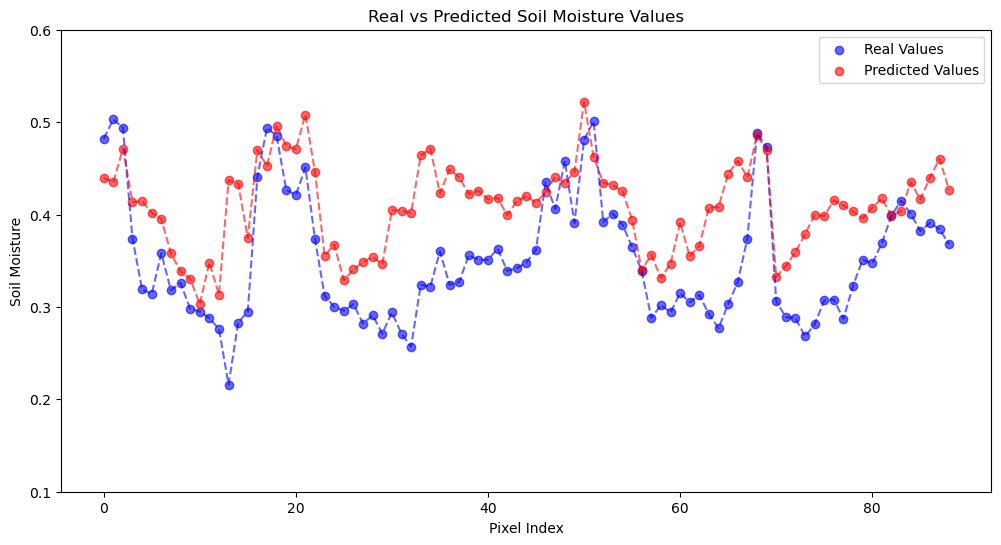

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def normalizingData(X, min_per, max_per):
    temp=(X - min_per) / (max_per - min_per)
    temp[temp>1]=1
    temp[temp<0]=0
    return temp

# Load real and predicted values
predicted = pd.read_csv('data_pre/output_result.csv')
gt = pd.read_csv('100m_data/output_tb/output_ndvi250_first/THAIBINH_101.csv')
# smap = pd.read_csv('abc/merged.csv')
# Extract real and predicted values
real_values = gt['sm_25'] if 'sm_25' in gt.columns else None
predicted_values = predicted['Prediction']
# smaps = smap['sm']

df = {'real values' : real_values, 'predictions' : predicted_values}
df = pd.DataFrame(df)

# Create a point plot
plt.figure(figsize=(12, 6))
if real_values is not None:
    plt.scatter(range(len(real_values)), real_values, label='Real Values', color='blue', alpha=0.6)
    plt.plot(range(len(real_values)), real_values, color='blue', alpha=0.6, linestyle='--')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values', color='red', alpha=0.6)
plt.plot(range(len(predicted_values)), predicted_values, color='red', alpha=0.6, linestyle='--')

plt.xlabel('Pixel Index')
plt.ylabel('Soil Moisture')
plt.title('Real vs Predicted Soil Moisture Values')
plt.legend()
plt.ylim(0.1, 0.6)

#### Compare predicted values vs Planet and SMAP ground truth

(0.1, 0.6)

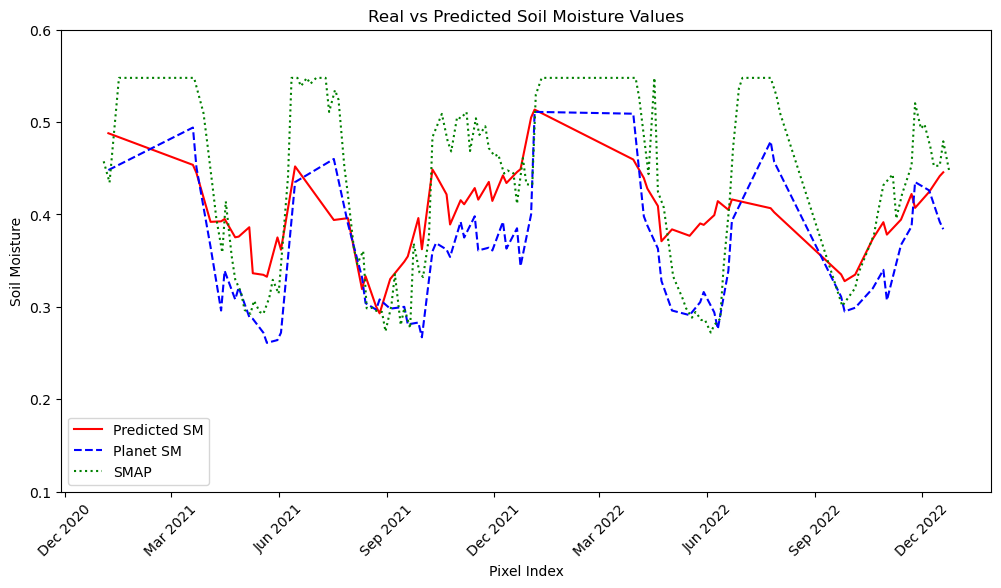

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def normalizingData(X, min_per, max_per):
    temp=(X - min_per) / (max_per - min_per)
    temp[temp>1]=1
    temp[temp<0]=0
    return temp

# Load real and predicted values
predicted = pd.read_csv('data_pre/output_result.csv')
gt = pd.read_csv('100m_data/output_tb/output_ndvi250_first/THAIBINH_130.csv')
smap = pd.read_csv('100m_data/output_tb/smap/130.csv')
# Extract real and predicted values
real_values = gt['sm_25'] if 'sm_25' in gt.columns else None
date_list = gt['date'] if 'date' in gt.columns else None
date_list = pd.to_datetime(date_list).to_list()
predicted_values = predicted['Prediction']
smap_values = smap['sm'] if 'sm' in smap.columns else None 
smap_dates = smap['date'] if 'date' in smap.columns else None 
smap_dates = pd.to_datetime(smap_dates).to_list()

df = {'real values' : real_values, 'predictions' : predicted_values}
df = pd.DataFrame(df)

# Create a point plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(date_list, predicted_values, color='red', alpha=1.0, label = 'Predicted SM')
if real_values is not None:
    ax.plot(date_list, real_values, color='blue', alpha=1.0, linestyle = '--', label = 'Planet SM')
ax.plot(smap_dates, smap_values, color = 'green', alpha=1.0, linestyle = ':', label = 'SMAP')

# Format x-axis as dates 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation = 45)

plt.xlabel('Pixel Index')
plt.ylabel('Soil Moisture')
plt.title('Real vs Predicted Soil Moisture Values')
plt.legend()
plt.ylim(0.1, 0.6)

(12393,)
12393


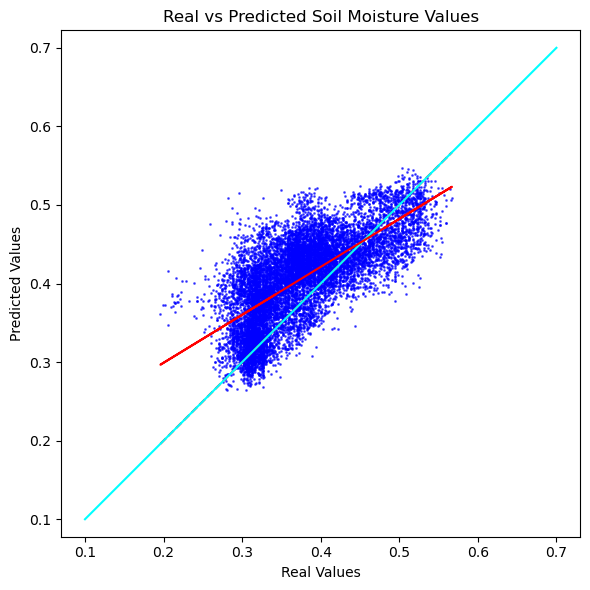

RMSE: 0.0557
Unbiased RMSE (ubRMSE): 0.0462
MAE: 0.0444
Pearson corr 0.7050


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats

# Load real and predicted values
predicted = pd.read_csv('/mnt/data2tb/Transfer-DenseSM-E_pack/data_pre/output_result.csv')
gt = pd.read_csv('100m_data/output_tb/tb_merged.csv')
# Extract real and predicted values
real_values = gt['sm_25'] if 'sm_25' in gt.columns else gt['sm']
predicted_values = predicted['Prediction']

print(real_values.shape)

mse = mean_squared_error(real_values, predicted_values)
rmse = np.sqrt(mse)
pearson_corr, pearson_p = scipy.stats.pearsonr(real_values, predicted_values)

# Calculate unbiased RMSE (ubRMSE)
bias = np.mean(predicted_values - real_values)
ubrmse = np.sqrt(np.mean(((predicted_values - real_values) - bias) ** 2))

# Calculate MAE
mae = mean_absolute_error(real_values, predicted_values)

# fit a trend line (linear regression) 
z = np.polyfit(real_values, predicted_values, 1)
p = np.poly1d(z)

print(len(real_values))
plt.figure(figsize = (6,6))
plt.scatter(real_values, predicted_values, color='blue', alpha=0.6, s=1)
plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], 'r--')
plt.plot([0.1, 0.7], [0.1, 0.7], label='Ideal (y = x)', color = 'cyan')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title(f'Real vs Predicted Soil Moisture Values')
plt.plot(real_values, p(real_values), "r-", label = 'Trend Line')

plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"RMSE: {rmse:.4f}")
print(f"Unbiased RMSE (ubRMSE): {ubrmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Pearson corr {pearson_corr:.4f}")

## Visualize ROI Inference

In [2]:
import rasterio
import numpy as np
import cv2
import pandas as pd

land_cover_path = 'roi_inference/thaibinh/data/land_cover/land_cover_100m.tif'

with rasterio.open(land_cover_path) as src:
    land_cover = src.read(1) 
    # filtered out classes: water : 0, built : 6, snow_and_ice : 8, flooded_vegetation = 3
    filtered_out_classes = [0, 3, 6, 8]
    mask = np.ones(src.shape, dtype=np.uint8)
    mask[np.isin(land_cover, filtered_out_classes)] = 0 
    np.save('roi_inference/thaibinh/data/land_cover/land_cover_mask.npy', mask)

In [4]:
# Read ground truth from tiff
target_date = '2021-12-21'
print('Target date : ', target_date)
tif_path = f'roi_inference/thaibinh/output/tif/{target_date}.tiff'
with rasterio.open(tif_path) as src:
    ground_truth = src.read(2) * 2.0
    print(src.shape)

# Read predicted values from CSV and reshape
predicted = pd.read_csv(f'/mnt/data2tb/Transfer-DenseSM-E_pack/roi_inference/thaibinh/prediction/{target_date}.csv')
predicted_values = np.array(predicted['Prediction']).reshape((244, 259))[1:, 1:]
mask = np.load('roi_inference/thaibinh/data/land_cover/land_cover_mask.npy')
ground_truth = np.where((ground_truth < 0.1) | (ground_truth > 0.7), np.nan, ground_truth)
predicted_values = np.where(np.isnan(ground_truth), np.nan, predicted_values)
mask = cv2.resize(mask, (ground_truth.shape[1], ground_truth.shape[0]), interpolation=cv2.INTER_NEAREST)
masked_predicted_values = np.where(mask == 0, np.nan, predicted_values)
masked_ground_truth = np.where(mask == 0, np.nan, ground_truth)

print('GT mean: ', np.nanmean(masked_ground_truth))
print('Prediction mean: ', np.nanmean(masked_predicted_values))



# Function to scale array to 0-255 using its own min/max
def scale_to_uint8(arr, arr_min, arr_max):
    arr_min = 0.1 
    arr_max = 0.7
    arr_scaled = (arr - arr_min) / (arr_max - arr_min)
    arr_scaled = np.clip(arr_scaled, 0, 1)
    return (arr_scaled * 255).astype(np.uint8)

# Scale both arrays
g_min = min(np.nanmin(ground_truth), np.nanmin(predicted_values))
g_max = max(np.nanmax(ground_truth), np.nanmax(predicted_values))
gt_uint8 = scale_to_uint8(ground_truth, g_min, g_max)
pred_uint8 = scale_to_uint8(predicted_values, g_min, g_max)

# Save as green channel PNGs
def save_green_png(arr_uint8, path, scale, mask = None):
    h, w = arr_uint8.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    rgb[..., 1] = arr_uint8
    # Resize the image to 8x larger using nearest neighbor for clear pixel boundaries
    rgb_large = cv2.resize(rgb, (w * scale, h * scale), interpolation=cv2.INTER_NEAREST)
    if mask is not None:
        if mask.shape != rgb_large.shape[:2]:
            print(f"Mask shape {mask.shape} does not match resized image shape {rgb_large.shape[:2]}")
            mask_resized = cv2.resize(mask, (rgb_large.shape[1], rgb_large.shape[0]), interpolation=cv2.INTER_NEAREST)
        else:
            mask_resized = mask
        # Apply mask: set all non-agriculture (mask==0) pixels to black
        rgb_large[mask_resized == 0] = 0
    cv2.imwrite(path, rgb_large)

save_green_png(gt_uint8, f'roi_inference/thaibinh/output/mask_{target_date}_ground_truth.png', 8, mask)
save_green_png(pred_uint8, f'roi_inference/thaibinh/output/mask_{target_date}_predicted.png', 8, mask)
save_green_png(gt_uint8, f'roi_inference/thaibinh/output/{target_date}_ground_truth.png', 8)
save_green_png(pred_uint8, f'roi_inference/thaibinh/output/{target_date}_predicted.png', 8)

print('Saved ground truth and predicted images with their own value ranges.')

Target date :  2021-12-21
(243, 258)
GT mean:  0.3886919
Prediction mean:  0.46611781585521417
Mask shape (243, 258) does not match resized image shape (1944, 2064)
Mask shape (243, 258) does not match resized image shape (1944, 2064)
Saved ground truth and predicted images with their own value ranges.


/tmp/ipykernel_8921/2589805394.py:30: RuntimeWarning: invalid value encountered in cast
  return (arr_scaled * 255).astype(np.uint8)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

tif_path = 'map_inference/data/2022-06-10_roi.tif'
with rasterio.open(tif_path) as src:
    ground_truth = src.read(2) * 2.0  # shape: (47, 47)

# Read predicted values from CSV and reshape
predicted = pd.read_csv('/mnt/data2tb/Transfer-DenseSM-E_2/data_pre/output_result.csv')
predicted_values = np.array(predicted['Prediction']).reshape((48, 48))[:-1, :-1]

# Replace NaN in predicted_values with its mean (ignoring NaNs)
if np.isnan(predicted_values).any():
    mean_pred = np.nanmean(predicted_values)
    predicted_values = np.where(np.isnan(predicted_values), mean_pred, predicted_values)

# Calculate unbiased RMSE (ubRMSE)
real_values = ground_truth
bias = np.mean(predicted_values - real_values)
rmse = np.sqrt(np.mean((predicted_values - real_values) ** 2))

print(f"Real Values Shape: {real_values.shape}, Predicted Shape: {predicted_values.shape}")
# Calculate MAE
mae = mean_absolute_error(real_values, predicted_values)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

ground_truth = ground_truth.flatten()[900:1100]
predicted_values = predicted_values.flatten()[900:1100]



print(f"Ground Truth Shape: {ground_truth.shape}, Predicted Shape: {predicted_values.shape}")
# Create a point plot
plt.figure(figsize=(12, 6))
if ground_truth is not None:
    plt.scatter(range(len(ground_truth)), ground_truth, label='Real Values', color='blue', alpha=0.6)
    plt.plot(range(len(ground_truth)), ground_truth, color='blue', alpha=0.6, linestyle='--')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values', color='red', alpha=0.6)
plt.plot(range(len(predicted_values)), predicted_values, color='red', alpha=0.6, linestyle='--')

plt.xlabel('Pixel Index')
plt.ylabel('Soil Moisture')
plt.title('Real vs Predicted Soil Moisture Values')
plt.legend()
plt.text(0.02, 0.95, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}', transform=plt.gca().transAxes, 
         fontsize=16, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.ylim(0.2, 0.6)

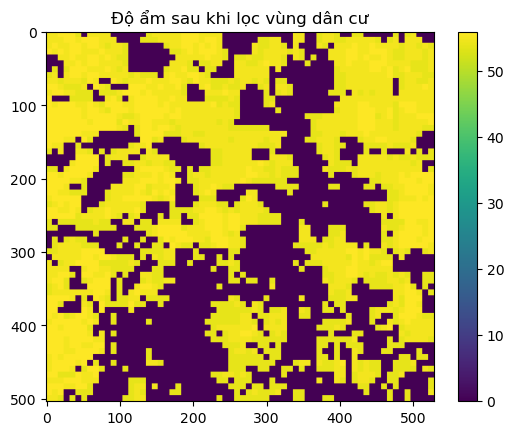

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from scipy.ndimage import label, find_objects 

# Giả sử bạn đã có mảng độ ẩm (ảnh 10x10)
img = cv2.imread('map_inference 2/output/new/ground_truth_green_no_mask.png', cv2.IMREAD_GRAYSCALE)
soil_moisture = np.asarray(img) / 255.

# Đặt ngưỡng, ví dụ <= 0.2 là vùng dân cư
threshold1 = 0.211
threshold2 = 0.3
land_use_mask = np.where((soil_moisture > threshold1) &(soil_moisture < threshold2), 1, 0)

residential_mask = np.array(1 - land_use_mask, dtype=np.uint8)  # Đảo ngược để lấy vùng dân cư

# Label the connected components 
structure = np.ones((3, 3))  # Kết nối 8 lân cận
labeled_array, num_features = label(land_use_mask, structure = structure)

# Lọc giá trị: giữ đất nông nghiệp, đặt dân cư = 0
filtered = img.copy()
filtered[land_use_mask == 0] = 0  # Đặt giá trị dân cư
np.save('map_inference 2/output/land_use_mask.npy', land_use_mask)

# Hiển thị
plt.imshow(filtered, cmap='viridis')
plt.title("Độ ẩm sau khi lọc vùng dân cư")
plt.colorbar()
plt.show()
